## Attribute Description :

#### Input variables : 
* url: URL of the article (non-predictive)
* timedelta: Days between the article publication and the dataset acquisition (non-predictive)
* n_tokens_title: Number of words in the title
* n_tokens_content: Number of words in the content
* n_unique_tokens: Rate of unique words in the content
* n_non_stop_words: Rate of non-stop words in the content
* n_non_stop_unique_tokens: Rate of unique non-stop words in the content
* num_hrefs: Number of links
* num_self_hrefs: Number of links to other articles published by Mashable
* num_imgs: Number of images
* num_videos: Number of videos
* average_token_length: Average length of the words in the content
* num_keywords: Number of keywords in the metadata
* data_channel_is_lifestyle: Is data channel 'Lifestyle'?
* data_channel_is_entertainment: Is data channel 'Entertainment'?
* data_channel_is_bus: Is data channel 'Business'?
* data_channel_is_socmed: Is data channel 'Social Media'?
* data_channel_is_tech: Is data channel 'Tech'?
* data_channel_is_world: Is data channel 'World'?
* kw_min_min: Worst keyword (min. shares)
* kw_max_min: Worst keyword (max. shares)
* kw_avg_min: Worst keyword (avg. shares)
* kw_min_max: Best keyword (min. shares)
* kw_max_max: Best keyword (max. shares)
* kw_avg_max: Best keyword (avg. shares)
* kw_min_avg: Avg. keyword (min. shares)
* kw_max_avg: Avg. keyword (max. shares)
* kw_avg_avg: Avg. keyword (avg. shares)
* self_reference_min_shares: Min. shares of referenced articles in Mashable
* self_reference_max_shares: Max. shares of referenced articles in Mashable
* self_reference_avg_sharess: Avg. shares of referenced articles in Mashable
* weekday_is_monday: Was the article published on a Monday?
* weekday_is_tuesday: Was the article published on a Tuesday?
* weekday_is_wednesday: Was the article published on a Wednesday?
* weekday_is_thursday: Was the article published on a Thursday?
* weekday_is_friday: Was the article published on a Friday?
* weekday_is_saturday: Was the article published on a Saturday?
* weekday_is_sunday: Was the article published on a Sunday?
* is_weekend: Was the article published on the weekend?
* LDA_00: Closeness to LDA topic 0
* LDA_01: Closeness to LDA topic 1
* LDA_02: Closeness to LDA topic 2
* LDA_03: Closeness to LDA topic 3
* LDA_04: Closeness to LDA topic 4
* global_subjectivity: Text subjectivity
* global_sentiment_polarity: Text sentiment polarity
* global_rate_positive_words: Rate of positive words in the content
* global_rate_negative_words: Rate of negative words in the content
* rate_positive_words: Rate of positive words among non-neutral tokens
* rate_negative_words: Rate of negative words among non-neutral tokens
* avg_positive_polarity: Avg. polarity of positive words
* min_positive_polarity: Min. polarity of positive words
* max_positive_polarity: Max. polarity of positive words
* avg_negative_polarity: Avg. polarity of negative words
* min_negative_polarity: Min. polarity of negative words
* max_negative_polarity: Max. polarity of negative words
* title_subjectivity: Title subjectivity
* title_sentiment_polarity: Title polarity
* abs_title_subjectivity: Absolute subjectivity level
* abs_title_sentiment_polarity: Absolute polarity level
* shares: Number of shares (target)

In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import requests
from bs4 import BeautifulSoup

sns.set_style('whitegrid')

In [286]:
rerun_basic_data_engineering = False

In [288]:
if rerun_basic_data_engineering:
    df = pd.read_csv('onlinenews.csv')
    df.columns = df.columns.map(lambda x: x.strip())
    df = df.rename(columns={'self_reference_avg_sharess':'self_reference_avg_shares'})
else:
    df = pd.read_csv('onlinenews_modified.csv')

### Data engineering

In [140]:
def get_data_channel(url):
    page = requests.get(df.loc[1]['url'])
    soup = BeautifulSoup(page.content, 'html.parser')
    return soup.select('hgroup[data-channel]>h2')[0].get_text().lower()

In [292]:
if rerun_basic_data_engineering:
    # date column
    df['date'] = df['url'].map(lambda x: '/'.join(x.split('/')[3:6][::-1]))
    
    # unify weekday columns
    df['weekday'] = 0
    for i, day in enumerate(['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']):
        df['weekday'] += (i + 1) * df[f'weekday_is_{day}']
    df = df.drop([i for i in df.columns if 'weekday_is' in i], axis=1)
    
    # replace data_channel_* features with single data_channel feature
    df['data_channel'] = ''
    data_channels = [i for i in df.columns if 'data_channel_' in i]
    for c in data_channels:
        df.loc[df[c] == 1,'data_channel'] = c.split('_')[-1]
    df = df.drop(data_channels,axis=1)
    
    # get missing data_channel values
    values = df[df['data_channel']=='']['data_channel'].copy()
    for i in df[df['data_channel']==''].index:
        try:
            values.loc[i] = get_data_channel(df.loc[i,'url'])
        except:
            1
    df.loc[df['data_channel']=='','data_channel'] = values

    df.loc[21386,'data_channel'] = 'world'
    df.loc[17003,'data_channel'] = 'entertainment'
    df = df.drop(622).reset_index().drop('index', axis=1)
    
    # save to csv
    df.to_csv('onlinenews_modified.csv', index=False)

## Analysis

### Outliers

In [257]:
percentile = 0.99
percentile_value = df['shares'].quantile(0.99)
print(f'Percentile value: {percentile_value:.0f}')
print(f'Max value: {df["shares"].max()}' )

Percentile value: 31658
Max value: 843300


<AxesSubplot:>

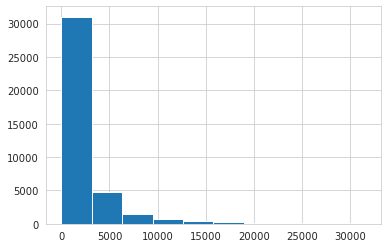

In [262]:
df[df['shares'] < percentile_value]['shares'].hist()

### data-channel counts

Text(0.5, 1.0, 'Channel counts')

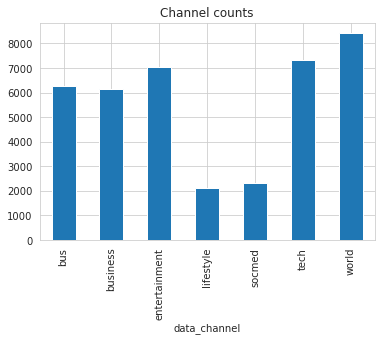

In [318]:
df.groupby('data_channel')['data_channel'].count().plot(kind='bar')
plt.title('Channel counts')

### Weekday histogram per data channel

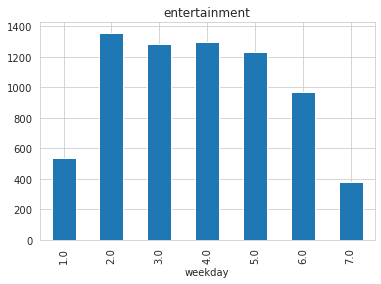

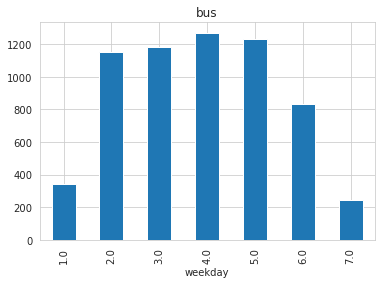

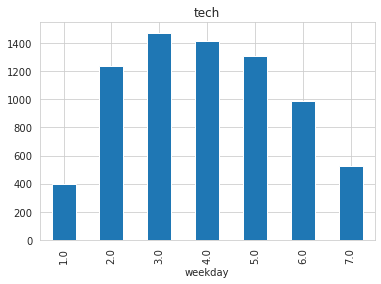

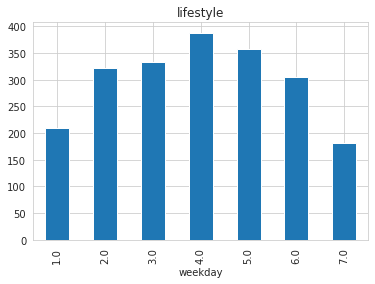

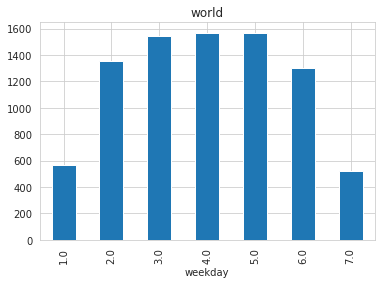

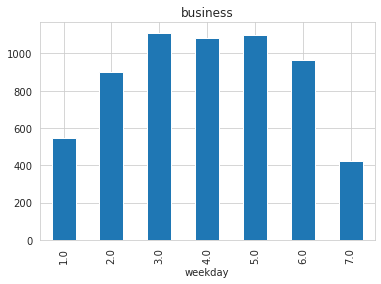

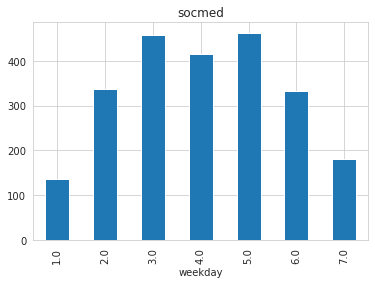

In [278]:
counts = {}
for i in df['data_channel'].unique():
    counts[i] = df[df['data_channel']==i].groupby('weekday')['shares'].count()
    counts[i].plot(kind='bar', title=i)
    plt.show()

Text(0.5, 1.0, 'Week-day number of shares correlation')

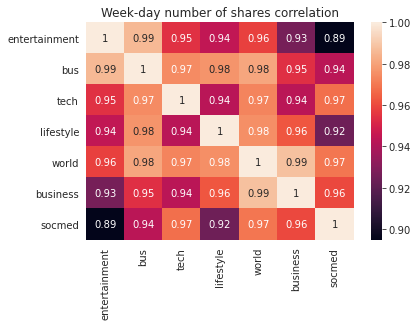

In [317]:
sns.heatmap(pd.DataFrame(counts).corr(), annot=True)
plt.title('Week-day number of shares correlation')

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39643 entries, 0 to 39642
Data columns (total 50 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   url                           39643 non-null  object 
 1   timedelta                     39643 non-null  float64
 2   n_tokens_title                39643 non-null  float64
 3   n_tokens_content              39643 non-null  float64
 4   n_unique_tokens               39643 non-null  float64
 5   n_non_stop_words              39643 non-null  float64
 6   n_non_stop_unique_tokens      39643 non-null  float64
 7   num_hrefs                     39643 non-null  float64
 8   num_self_hrefs                39643 non-null  float64
 9   num_imgs                      39643 non-null  float64
 10  num_videos                    39643 non-null  float64
 11  average_token_length          39643 non-null  float64
 12  num_keywords                  39643 non-null  float64
 13  k